In [1]:
from itertools import islice

import networkx as nx
import numpy as np

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
import matching.misc.cpg_const as cpg_const
from matching.glema.common.dataset import DesignPatternDataset
from matching.glema.common.model import InferenceGNN

In [2]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "CPG_augm_large"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
args = arg_utils.load_args( args, model_name )

args.pattern_dataset = "CPG_all"
args.normalized = True
args.test_data = True
args.batch_size = 128
args.num_workers = 1

In [3]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/CPG_augm_large_undirected_anchored_v1/model.pt ...


In [4]:
dataset = DesignPatternDataset( args, max_pattern_examples=30, query_pattern=False )
up_sources = dataset.get_sources()
up_patterns = dataset.get_patterns()

Loading sources from CPG_augm_large ...


100%|██████████| 1220/1220 [00:00<00:00, 4421.50it/s]


Loading sources from CPG_all ...


100%|██████████| 22072/22072 [00:04<00:00, 5034.02it/s]


In [5]:
p_sources = up_sources
p_sources = epm.filter_sources( p_sources, dataset.get_source_patterns(), max_sources_per_pattern=10 )
p_sources = epm.normalize_sources( p_sources, max_distance=8 )

p_patterns = up_patterns
#p_patterns = epm.normalize_patterns( p_patterns, max_distance=8 )
p_patterns = epm.normalize_patterns_by_presence( p_patterns,
                                                 num_graphs=4, max_distance=6,
                                                 n_start=20, n_decay=4 )
"""
p_patterns = epm.normalize_patterns_by_presence( p_patterns,
                                                 num_graphs=4, max_distance=6,
                                                 n_start=30, n_decay=2 )
"""
dataset.set_sources( p_sources )
dataset.set_patterns( p_patterns )
dataset.compute_samples()

Filtering sources ...


100%|██████████| 1220/1220 [00:00<00:00, 3969783.46it/s]


Normalizing sources ...


100%|██████████| 72/72 [00:02<00:00, 34.90it/s] 


Normalizing patterns to connected ...


100%|██████████| 7/7 [00:00<00:00, 61.71it/s]


Filter connected patterns by presence ...


100%|██████████| 7/7 [00:00<00:00, 17848.10it/s]


In [6]:
source_pattern_counts = { }
for gidx, pattern in dataset.get_source_patterns().items():
    if gidx not in dataset.get_sources():
        continue
    if pattern not in source_pattern_counts:
        source_pattern_counts[ pattern ] = 0
    source_pattern_counts[ pattern ] += 1
print( "source_pattern_counts:", misc_utils.sort_dict_by_key( source_pattern_counts ) )

pattern_example_counts = { dp: len( l ) for dp, l in dataset.get_patterns().items() }
print( "pattern_example_counts:", misc_utils.sort_dict_by_key( pattern_example_counts ) )

source_pattern_counts: {'ABSTRACT_FACTORY': 10, 'ADAPTER': 10, 'BUILDER': 10, 'FACADE': 7, 'FACTORY_METHOD': 10, 'N/A': 10, 'OBSERVER': 10, 'SINGLETON': 5}
pattern_example_counts: {'ABSTRACT_FACTORY': 4, 'ADAPTER': 4, 'BUILDER': 4, 'FACADE': 4, 'FACTORY_METHOD': 4, 'OBSERVER': 4, 'SINGLETON': 4}


In [7]:
def sample_processor_path_match_weighted( source: nx.Graph, query: nx.Graph, meta: dict ) -> tuple[ list, list, list ]:
    source_paths = set( [ path[ 1 ] for path in graph_utils.get_all_norm_paths( source ) ] )
    query_paths = set( [ path[ 1 ] for path in graph_utils.get_all_norm_paths( query ) ] )
    max_match = 0
    for sp in source_paths:
        for qp in query_paths:
            for k in list( range( 1, min( len( sp ), len( qp ) ) + 1 ) ):
                qpk = qp[ :k ]
                if sp.startswith( qpk ) and len( qpk ) > max_match:
                    max_match = len( qpk )

    pred_w = max_match / max( [ len( p ) for p in source_paths ] )
    _meta = meta.copy()
    _meta[ "pred_w" ] = pred_w
    return epm.sample_processor_default( source, query, _meta )

In [8]:
preds, metas, sources, queries = epm.inference( model, dataset, args,
                                                sample_processor=epm.sample_processor_subgraph_normalized,
                                                #sample_processor=epm.sample_processor_k_normalized,
                                                #min_d_offset=1, max_d_offset=5,
                                                collect_graphs=True )

print( f"source: {len( sources )} / queries: {len( queries )}" )
print( f"preds: {len( preds )} / metas: {len( metas )}" )
print( "meta example:", metas[ 0 ] )

Inference of dataset ...


100%|██████████| 16/16 [00:01<00:00, 10.10it/s]

source: 2016 / queries: 2016
preds: 2016 / metas: 2016
meta example: {'source_type': 'FACTORY_METHOD', 'pattern_type': 'FACTORY_METHOD', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'n_match': 4, 'n_not_match': 2, 'pred_w': 1.0, 'pred_r': 0.9}


In [9]:
def aggregate_preds_max( preds: list[ float ] ) -> float:
    return float( np.max( preds ) )

In [10]:
groups_by_source = epm.group_by_source( metas )
source_preds = epm.compute_source_preds( groups_by_source, preds, metas,
                                         #pred_aggregator=epm.aggregate_preds_mean )
                                         #pred_aggregator=aggregate_preds_max )
                                         pred_aggregator=epm.aggregate_preds_by_quantile, q=0.9 )
source_types = epm.compute_source_types( metas )
true_labels, pred_labels, pred_scores = epm.compute_labels( source_types, source_preds,
                                                            conf=0.5, top_k=1 )

for k, v in islice( source_types.items(), 3 ):
    print( f"type::{k}={source_types[ k ]}" )
    print( f"group::{k}={groups_by_source[ k ]}" )
    print( f"pred::{k}={source_preds[ k ]}\n" )

type::259=FACTORY_METHOD
group::259={'FACTORY_METHOD': [0, 1, 2, 3], 'OBSERVER': [4, 5, 6, 7], 'ADAPTER': [8, 9, 10, 11], 'BUILDER': [12, 13, 14, 15], 'FACADE': [16, 17, 18, 19], 'SINGLETON': [20, 21, 22, 23], 'ABSTRACT_FACTORY': [24, 25, 26, 27]}
pred::259={'FACTORY_METHOD': 0.8325, 'OBSERVER': 0.23863088965415954, 'ADAPTER': 0.23737417320907114, 'BUILDER': 0.42825102476030596, 'FACADE': 0.07951564905233682, 'SINGLETON': 0.16872404788434509, 'ABSTRACT_FACTORY': 0.004564699748705608}

type::660=FACTORY_METHOD
group::660={'FACTORY_METHOD': [28, 29, 30, 31], 'OBSERVER': [32, 33, 34, 35], 'ADAPTER': [36, 37, 38, 39], 'BUILDER': [40, 41, 42, 43], 'FACADE': [44, 45, 46, 47], 'SINGLETON': [48, 49, 50, 51], 'ABSTRACT_FACTORY': [52, 53, 54, 55]}
pred::660={'FACTORY_METHOD': 0.9, 'OBSERVER': 0.9503281534910203, 'ADAPTER': 0.9458331322073936, 'BUILDER': 0.782359340429306, 'FACADE': 0.9251903902888298, 'SINGLETON': 0.4991017263480463, 'ABSTRACT_FACTORY': 0.9350100406408309}

type::637=FACTORY_MET

In [11]:
x_labels, y_labels = epm.to_numeric_labels( true_labels, pred_labels )
metrics = epm.compute_metrics( x_labels, y_labels )
print( f"Roc=[{metrics[ 'roc' ]:.3}] Acc=[{metrics[ 'acc' ]:.3}] "
       f"Prec=[{metrics[ 'pre' ]:.3}] Rec=[{metrics[ 'rec' ]:.3}] F1=[{metrics[ 'f1s' ]:.3}] "
       f"AvgPrec=[{metrics[ 'avp' ]:.3}]" )

Roc=[0.864] Acc=[0.764] Prec=[0.846] Rec=[0.764] F1=[0.767] AvgPrec=[0.667]


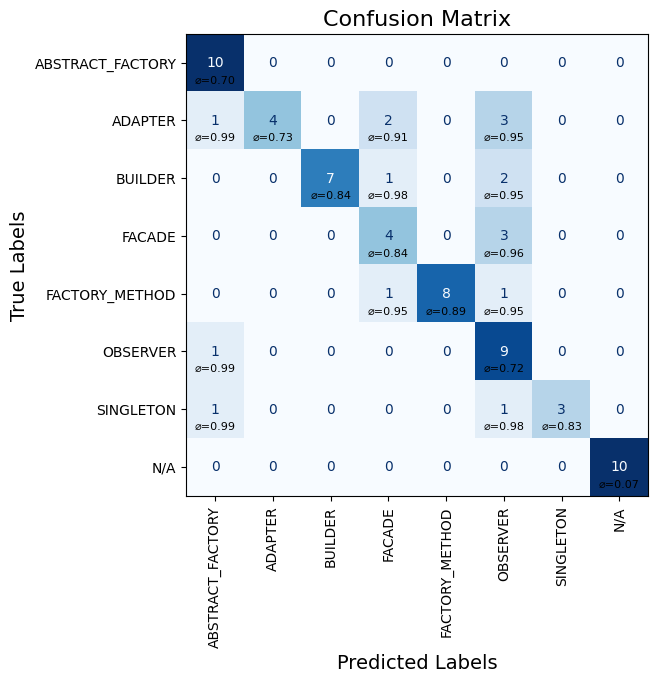

In [12]:
epm.compute_cm( true_labels, pred_labels, pred_scores )

Should be: FACTORY_METHOD
FACTORY_METHOD: 0.833
BUILDER: 0.428
OBSERVER: 0.239
ADAPTER: 0.237
SINGLETON: 0.169
FACADE: 0.0795
ABSTRACT_FACTORY: 0.00456
{'source_type': 'FACTORY_METHOD', 'pattern_type': 'FACTORY_METHOD', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'n_match': 4, 'n_not_match': 2, 'pred_w': 1.0, 'pred_r': 0.9}


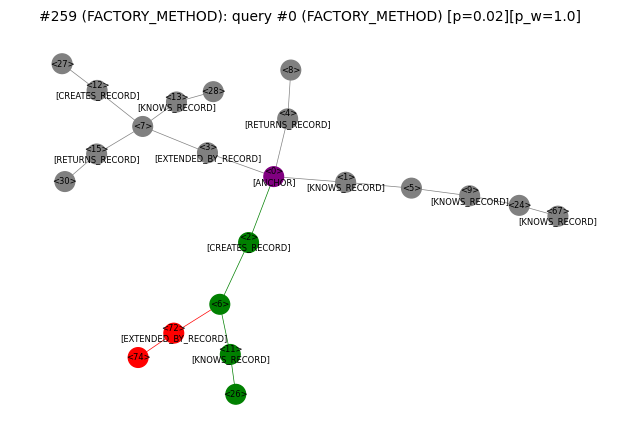

{'source_type': 'FACTORY_METHOD', 'pattern_type': 'OBSERVER', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'n_match': 2, 'n_not_match': 4, 'pred_w': 0.2475}


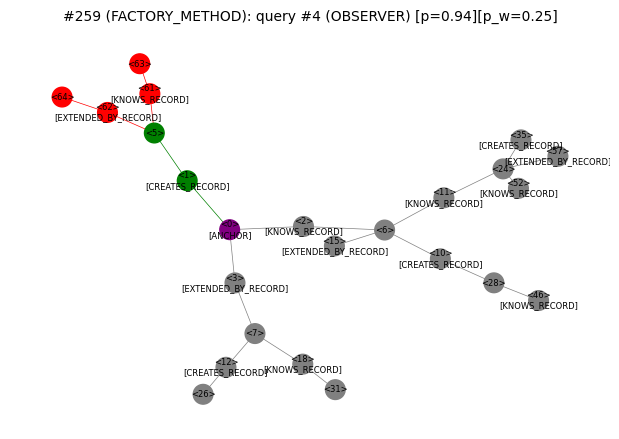

{'source_type': 'FACTORY_METHOD', 'pattern_type': 'ADAPTER', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'n_match': 2, 'n_not_match': 4, 'pred_w': 0.2475}


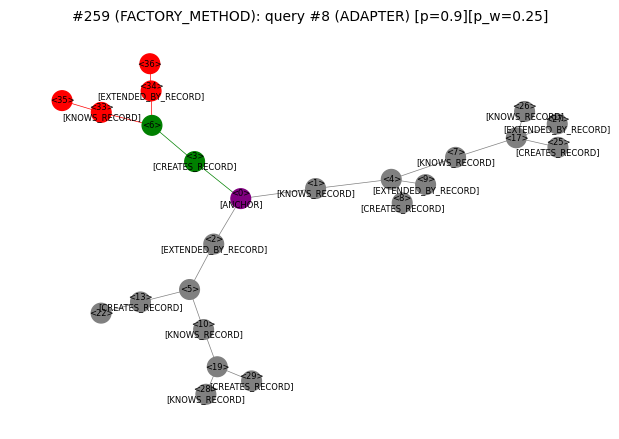

{'source_type': 'FACTORY_METHOD', 'pattern_type': 'BUILDER', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'n_match': 4, 'n_not_match': 2, 'pred_w': 0.61875}


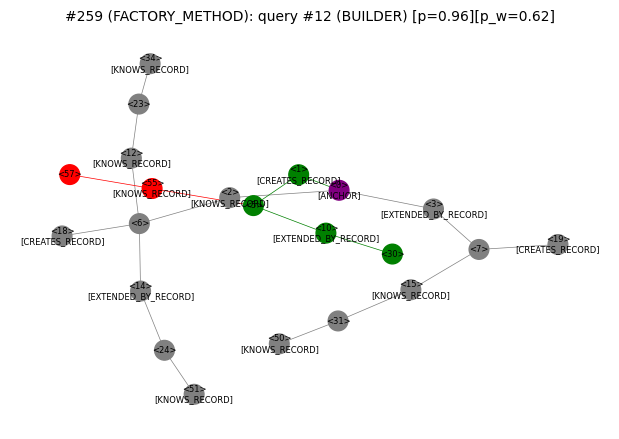

{'source_type': 'FACTORY_METHOD', 'pattern_type': 'FACADE', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'n_match': 4, 'n_not_match': 2, 'pred_w': 0.61875}


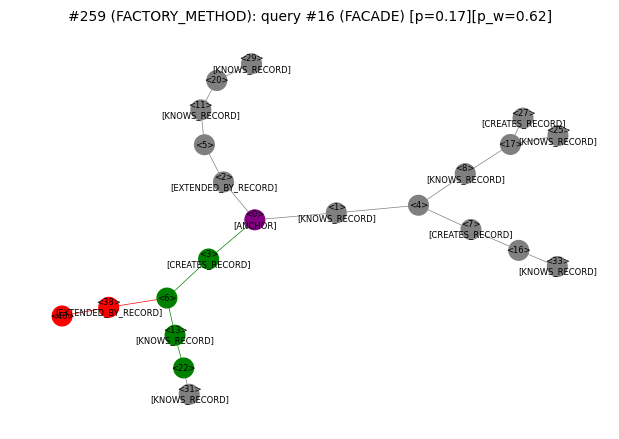

{'source_type': 'FACTORY_METHOD', 'pattern_type': 'SINGLETON', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'n_match': 1, 'n_not_match': 5, 'pred_w': 0.2475}


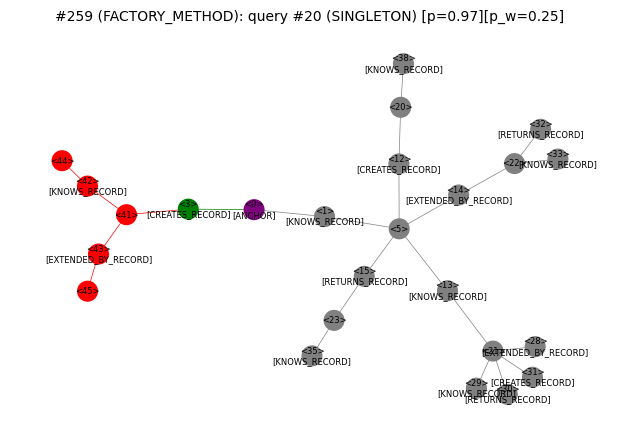

{'source_type': 'FACTORY_METHOD', 'pattern_type': 'ABSTRACT_FACTORY', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'n_match': 2, 'n_not_match': 4, 'pred_w': 0.2475}


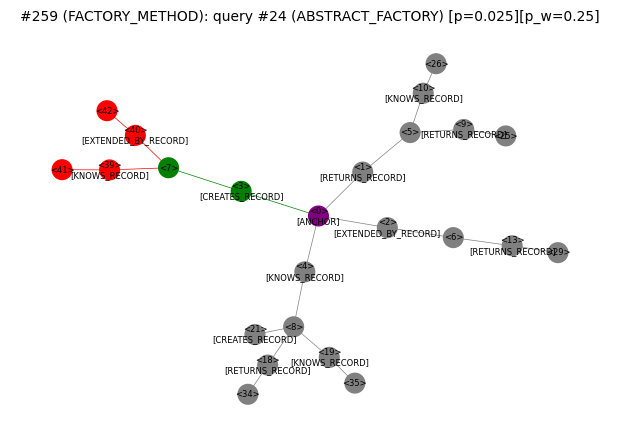

In [13]:
matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
example_gidx = next( iter( groups_by_source ) )
print( f"Should be: {dataset.get_source_patterns()[ example_gidx ]}" )
for pattern_type, score in misc_utils.sort_dict_by_value(
        source_preds[ example_gidx ], reverse=True ).items():
    print( f"{pattern_type}: {score:.3}" )
for pattern_type, idxs in groups_by_source[ example_gidx ].items():
    for idx in idxs[ :1 ]:
        source = sources[ idx ]
        query = queries[ idx ]
        pred = preds[ idx ]
        meta = metas[ idx ]
        print( meta )
        source_type = meta.get( "source_type" )
        gidx = meta.get( "gidx" )
        p_w = meta.get( "pred_w", 1.0 )
        combined, node_colors, edge_colors = graph_utils.combine_normalized(
            source, query, matching_colors=matching_colors )
        plot_utils.plot_graph( combined,
                               title=f"#{gidx} ({source_type}): query #{idx} ({pattern_type}) [p={pred:.2}][p_w={p_w:.2}]",
                               nodeLabels=graph_utils.get_node_labels( combined ),
                               nodeColors=node_colors, edgeColors=edge_colors )